In [1]:
from Bio import SeqIO
from pprint import pprint
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import build_vocab_from_iterator
import ast
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/homebrew/anaconda3/envs/AIMA05/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/homebrew/anaconda3/envs/AIMA05/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/opt/homebrew/anaconda3/envs/AIMA05/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/homebrew/anaconda3/envs/AIMA05/lib/python3.10/site-packages/traitlets/config/application.py", lin

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed = 59
set_seed(seed)

# 1. Data preparation

In [3]:
df_proteins = pd.read_parquet("data_preparation/all_proteins_with_fold.parquet")
print(df_proteins.shape)
display(df_proteins.head())

(1169, 13)


,id,sequence,seq_len,binding_sites,num_residues,target,sites_pos_min,sites_pos_max,sites_pos_mean,sites_pos_std,sites_pos_median,is_duplicate,fold
0,Q5LL55,MSETWLPTLVTATPQEGFDLAVKLSRIAVKKTQPDAQVRDTLRAVY...,76,"[53, 46, 32, 42, 25, 60, 56, 43, 57, 31, 54, 2...",17,small,22,60,40.529412,11.887302,40,False,1
1,H9L4N9,MQINIQGHHIDLTDSMQDYVHSKFDKLERFFDHINHVQVILRVEKL...,95,"[51, 62, 42, 60, 55, 64]",6,metal,42,64,55.666667,7.498148,60,False,1
2,O34738,MKSWKVKEIVIMSVISIVFAVVYLLFTHFGNVLAGMFGPIAYEPIY...,199,"[100, 46, 104, 88, 63, 42, 77, 135, 91, 108, 2...",22,small,23,135,86.227273,34.010602,95,False,1
3,P39579,MDFKQEVLDVLAEVCQDDIVKENPDIEIFEEGLLDSFGTVELLLAI...,78,"[37, 36, 40, 61]",4,small,36,61,43.500000,10.210289,40,False,1
4,P01887,MARSVTLVFLVLVSLTGLYAIQKTPQIQVYSRHPPENGKPNILNCY...,119,"[83, 77]",2,metal,77,83,80.000000,3.000000,83,True,1


In [4]:
# check sample in the dataset with min sequence length
min_seq_len = df_proteins["seq_len"].min()
min_idx = df_proteins[df_proteins["seq_len"] == min_seq_len].index[0]

# print sample sequence and binding sites
print("Sequence:", df_proteins["sequence"].loc[min_idx])
print("Binding sites:", df_proteins["binding_sites"].loc[min_idx])

Sequence: MLAIVAYIGFLALFTGIAAGLLFGLRSAKIL
Binding sites: [ 8 12 16  3 23 15  4  7]


In [5]:
# print min, max sequence length
min_seq_len = df_proteins["seq_len"].min()
max_seq_len = df_proteins["seq_len"].max()
print("Min sequence length:", min_seq_len)
print("Max sequence length:", max_seq_len)

Min sequence length: 31
Max sequence length: 556


## 1.1.Create vocabulary

In [6]:
def antigen_tokenizer(antigen):
    return [aa for aa in antigen]


def create_vocab(data, vocab_size):
    # Create a function to yield list of tokens
    def yield_tokens(antigens):
        for seq in antigens:
            yield antigen_tokenizer(seq)

    # Create vocabulary
    vocab = build_vocab_from_iterator(
        yield_tokens(data), max_tokens=vocab_size, specials=["<pad>", "<unk>"]
    )
    vocab.set_default_index(vocab["<unk>"])
    return vocab

In [7]:
vocab = create_vocab(df_proteins["sequence"], 30)
dict(sorted(vocab.get_stoi().items(), key=lambda item: item[1]))

{'<pad>': 0,
 '<unk>': 1,
 'L': 2,
 'A': 3,
 'E': 4,
 'G': 5,
 'V': 6,
 'S': 7,
 'K': 8,
 'D': 9,
 'I': 10,
 'T': 11,
 'R': 12,
 'P': 13,
 'N': 14,
 'F': 15,
 'Q': 16,
 'Y': 17,
 'M': 18,
 'H': 19,
 'C': 20,
 'W': 21,
 'U': 22,
 'X': 23}

## 1.2.Create dataset

In [8]:
class EpitopeDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [9]:
def vectorize_amino_acids(antigen, vocab, max_len):
    encoded_seq = vocab(antigen_tokenizer(antigen))
    num_pads = max_len - len(antigen)
    encoded_seq += [vocab["<pad>"]] * num_pads
    return encoded_seq


def prepare_dataset(df, vocab, max_len):
    # encoding aminio acids
    X = [vectorize_amino_acids(seq, vocab, max_len) for seq in df["sequence"]]

    # residues to one-hot
    n_seq = df.shape[0]
    Y = np.zeros((n_seq, max_len))
    for i, labels in enumerate(df["binding_sites"]):
        for pos in labels:
            # -1 because the first position in array is 0
            Y[i, pos - 1] = 1

    return EpitopeDataset(X, Y)

In [10]:
# split into different folds based on column "fold"
n_folds = 5
fold_datasets = []
for fold in range(n_folds):
    dataset = prepare_dataset(
        df=df_proteins[df_proteins["fold"] == fold + 1],
        vocab=vocab,
        max_len=max_seq_len,
    )
    fold_datasets.append(dataset)

# check the number of samples in each fold
for i, fold_data in enumerate(fold_datasets):
    print(f"Fold {i}: {len(fold_data)} samples")

Fold 0: 234 samples
Fold 1: 229 samples
Fold 2: 232 samples
Fold 3: 236 samples
Fold 4: 238 samples


In [11]:
# check sample in the dataset with min sequence length
fold1_dataset = fold_datasets[0]
X_i, y_i = fold1_dataset[0]
print("X shape:", len(X_i))
print("X:", X_i[:30])
print("Y shape:", y_i.shape)
print("Y:", y_i[:30])

X shape: 556
X: [18, 7, 4, 11, 21, 2, 13, 11, 2, 6, 11, 3, 11, 13, 16, 4, 5, 15, 9, 2, 3, 6, 8, 2, 7, 12, 10, 3, 6, 8]
Y shape: (556,)
Y: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 1. 1. 0. 0. 1. 0.]


In [12]:
seq_length = max_seq_len


def collate_batch(batch):
    # create inputs, offsets, labels for batch
    sentences, labels = list(zip(*batch))
    encoded_sentences = [
        (
            sentence + ([0] * (seq_length - len(sentence)))
            if len(sentence) < seq_length
            else sentence[:seq_length]
        )
        for sentence in sentences
    ]

    encoded_sentences = torch.tensor(encoded_sentences, dtype=torch.int64)
    labels = torch.tensor(labels)

    return encoded_sentences, labels

In [13]:
batch_size = 128

train_dataloader = DataLoader(
    fold_datasets[0], batch_size=batch_size, shuffle=True, collate_fn=collate_batch
)

valid_dataloader = DataLoader(
    fold_datasets[1], batch_size=batch_size, shuffle=False, collate_fn=collate_batch
)

test_dataloader = DataLoader(
    fold_datasets[2], batch_size=batch_size, shuffle=False, collate_fn=collate_batch
)

In [14]:
encoded_sentences, labels = next(iter(train_dataloader))
print("Encoded sentences shape:", encoded_sentences.shape)
print("Labels shape:", labels.shape)

Encoded sentences shape: torch.Size([128, 556])
Labels shape: torch.Size([128, 556])


# 2. Model Definition

In [15]:
class RNNEpitopeModel(nn.Module):
    def __init__(
        self, vocab_size=21, embedding_dim=4, hidden_size=3, activation="relu"
    ):
        super(RNNEpitopeModel, self).__init__()

        # define embedding layers
        self.embedding_dim = embedding_dim
        self.embedding_layer = nn.Embedding(
            num_embeddings=vocab_size, embedding_dim=embedding_dim
        )

        # define RNN layer
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(
            input_size=self.embedding_dim,
            hidden_size=self.hidden_size,
            num_layers=1,
            nonlinearity=activation,
            batch_first=True,
        )

        # Change output size to 1 since we want binary classification per position
        self.fc = nn.Linear(self.hidden_size, 1)

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        rnn_output, _ = self.rnn(embeddings)
        logits = self.fc(rnn_output)
        return logits.squeeze(-1)

In [16]:
model = RNNEpitopeModel(vocab_size=len(vocab))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
model = model.to(device)
model

Device: cpu


RNNEpitopeModel(
  (embedding_layer): Embedding(24, 4)
  (rnn): RNN(4, 3, batch_first=True)
  (fc): Linear(in_features=3, out_features=1, bias=True)
)

In [17]:
encoded_sentences, labels = next(iter(train_dataloader))
encoded_sentences = encoded_sentences.to(device)
predictions = model(encoded_sentences.to(device))
print("Predictions shape:", predictions.shape)
print("Predictions:", predictions[:20])

Predictions shape: torch.Size([128, 556])
Predictions: tensor([[-0.0046,  0.2239,  0.0773,  ..., -0.0629, -0.0629, -0.0629],
        [-0.0046, -0.0021,  0.1950,  ..., -0.0629, -0.0629, -0.0629],
        [-0.0046, -0.0545,  0.0857,  ..., -0.0629, -0.0629, -0.0629],
        ...,
        [-0.0046, -0.1369,  0.0734,  ..., -0.0629, -0.0629, -0.0629],
        [-0.0046,  0.1985, -0.2619,  ..., -0.0629, -0.0629, -0.0629],
        [-0.0046,  0.1108, -0.5659,  ..., -0.0629, -0.0629, -0.0629]],
       grad_fn=<SliceBackward0>)


In [18]:
fold_datasets[0].Y[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

# 3. Training

In [19]:
def calculate_auc(logits, labels):
    # Convert logits to probabilities
    probs = torch.sigmoid(logits)

    # Sort predictions and corresponding labels
    sorted_probs, sort_idx = torch.sort(probs, descending=True)
    sorted_labels = labels[sort_idx]

    # Calculate TPR and FPR
    tpr = torch.cumsum(sorted_labels, dim=0)
    fpr = torch.cumsum(1 - sorted_labels, dim=0)

    # Normalize TPR and FPR
    tpr = tpr / tpr[-1]
    fpr = fpr / fpr[-1]

    # Calculate AUC using trapezoidal rule
    auc = torch.trapz(tpr, fpr)

    return auc.item()

In [20]:
def train_epoch(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_loss = 0
    all_logits = []
    all_labels = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(inputs)
        
        # Compute loss
        loss = criterion(logits, labels)
        total_loss += loss.item()

        # Backward and optimize
        loss.backward()
        optimizer.step()

        all_logits.append(logits.detach())
        all_labels.append(labels)

        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| loss {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_loss / log_interval
                )
            )
            total_loss = 0
            start_time = time.time()

    # Concatenate all batches
    all_logits = torch.cat(all_logits, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    # Convert logits to probabilities
    probs = torch.sigmoid(all_logits)

    # Convert probabilities to binary predictions
    binary_preds = (probs > 0.5).float()

    # Flatten the tensors
    flat_preds = binary_preds.view(-1)
    flat_labels = all_labels.view(-1)
    flat_logits = all_logits.view(-1)

    # Calculate metrics
    accuracy = (flat_preds == flat_labels).float().mean()

    true_positives = (flat_preds * flat_labels).sum()
    predicted_positives = flat_preds.sum()
    actual_positives = flat_labels.sum()

    precision = true_positives / (predicted_positives + 1e-8)
    recall = true_positives / (actual_positives + 1e-8)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)

    # Calculate AUC
    auc = calculate_auc(flat_logits, flat_labels)

    # Calculate average loss
    avg_loss = total_loss / len(train_dataloader)

    return {
        'loss': avg_loss,
        'accuracy': accuracy.item(),
        'precision': precision.item(),
        'recall': recall.item(),
        'f1': f1.item(),
        'auc': auc
    }

In [21]:
def evaluate_epoch(model, criterion, valid_dataloader, device):
    model.eval()
    total_loss = 0
    all_logits = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in valid_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            logits = model(inputs)
            loss = criterion(logits, labels)
            total_loss += loss.item()

            all_logits.append(logits)
            all_labels.append(labels)

    # Concatenate all batches
    all_logits = torch.cat(all_logits, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    # Convert logits to probabilities
    probs = torch.sigmoid(all_logits)

    # Convert probabilities to binary predictions
    binary_preds = (probs > 0.5).float()

    # Flatten the tensors
    flat_preds = binary_preds.view(-1)
    flat_labels = all_labels.view(-1)
    flat_logits = all_logits.view(-1)

    # Calculate metrics
    accuracy = (flat_preds == flat_labels).float().mean()

    true_positives = (flat_preds * flat_labels).sum()
    predicted_positives = flat_preds.sum()
    actual_positives = flat_labels.sum()

    precision = true_positives / (predicted_positives + 1e-8)
    recall = true_positives / (actual_positives + 1e-8)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)

    # Calculate AUC
    auc = calculate_auc(flat_logits, flat_labels)

    # Calculate average loss
    avg_loss = total_loss / len(valid_dataloader)

    return {
        'loss': avg_loss,
        'accuracy': accuracy.item(),
        'precision': precision.item(),
        'recall': recall.item(),
        'f1': f1.item(),
        'auc': auc
    }

In [22]:
import time
import torch
import numpy as np

def train(
    model,
    model_name,
    save_model,
    optimizer,
    criterion,
    train_dataloader,
    valid_dataloader,
    num_epochs,
    device,
):
    train_metrics = {
        'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []
    }
    eval_metrics = {
        'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []
    }
    best_eval_loss = float('inf')
    times = []

    for epoch in range(1, num_epochs + 1):
        epoch_start_time = time.time()

        # Training
        train_results = train_epoch(
            model, optimizer, criterion, train_dataloader, device, epoch
        )
        for key in train_metrics:
            train_metrics[key].append(train_results[key])

        # Evaluation
        eval_results = evaluate_epoch(model, criterion, valid_dataloader, device)
        for key in eval_metrics:
            eval_metrics[key].append(eval_results[key])

        # Save best model
        if eval_results['loss'] < best_eval_loss:
            best_eval_loss = eval_results['loss']
            torch.save(model.state_dict(), f"{save_model}/{model_name}.pt")

        times.append(time.time() - epoch_start_time)

        # Print metrics at end of epoch
        print("-" * 89)
        print(
            f"| End of epoch {epoch:3d} | Time: {times[-1]:5.2f}s | "
            f"Train Loss: {train_results['loss']:.3f} | Train AUC: {train_results['auc']:.3f} | "
            f"Valid Loss: {eval_results['loss']:.3f} | Valid AUC: {eval_results['auc']:.3f}"
        )
        print("-" * 89)

    # Load best model
    model.load_state_dict(torch.load(f"{save_model}/{model_name}.pt"))
    model.eval()

    metrics = {
        "train": train_metrics,
        "valid": eval_metrics,
        "time": times,
    }

    return model, metrics

In [23]:
def plot_result(metrics):
    num_epochs = len(metrics['train']['loss'])
    epochs = list(range(1, num_epochs + 1))

    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))
    fig.suptitle('Training and Validation Metrics', fontsize=16)

    metric_pairs = [
        ('loss', 'Loss'),
        ('accuracy', 'Accuracy'),
        ('precision', 'Precision'),
        ('recall', 'Recall'),
        ('f1', 'F1 Score'),
        ('auc', 'AUC-ROC')
    ]

    for idx, (metric, title) in enumerate(metric_pairs):
        row = idx // 2
        col = idx % 2
        
        axs[row, col].plot(epochs, metrics['train'][metric], label="Training")
        axs[row, col].plot(epochs, metrics['valid'][metric], label="Validation")
        axs[row, col].set_xlabel("Epochs")
        axs[row, col].set_ylabel(title)
        axs[row, col].set_title(f'{title}')
        axs[row, col].legend()
        axs[row, col].grid(True)

    plt.tight_layout()
    plt.show()

In [24]:
%%time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

model = RNNEpitopeModel(vocab_size=len(vocab))
model.to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 500
save_model = "./model"
os.makedirs(save_model, exist_ok=True)
model_name = "model"

model, metrics = train(
    model,
    model_name,
    save_model,
    optimizer,
    criterion,
    train_dataloader,
    valid_dataloader,
    num_epochs,
    device,
)

Using device cpu
-----------------------------------------------------------------------------------------
| End of epoch   1 | Time:  0.11s | Train Loss: 0.580 | Train AUC: 0.341 | Valid Loss: 0.578 | Valid AUC: 0.358
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch   2 | Time:  0.10s | Train Loss: 0.579 | Train AUC: 0.342 | Valid Loss: 0.578 | Valid AUC: 0.358
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch   3 | Time:  0.10s | Train Loss: 0.578 | Train AUC: 0.342 | Valid Loss: 0.577 | Valid AUC: 0.358
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch   

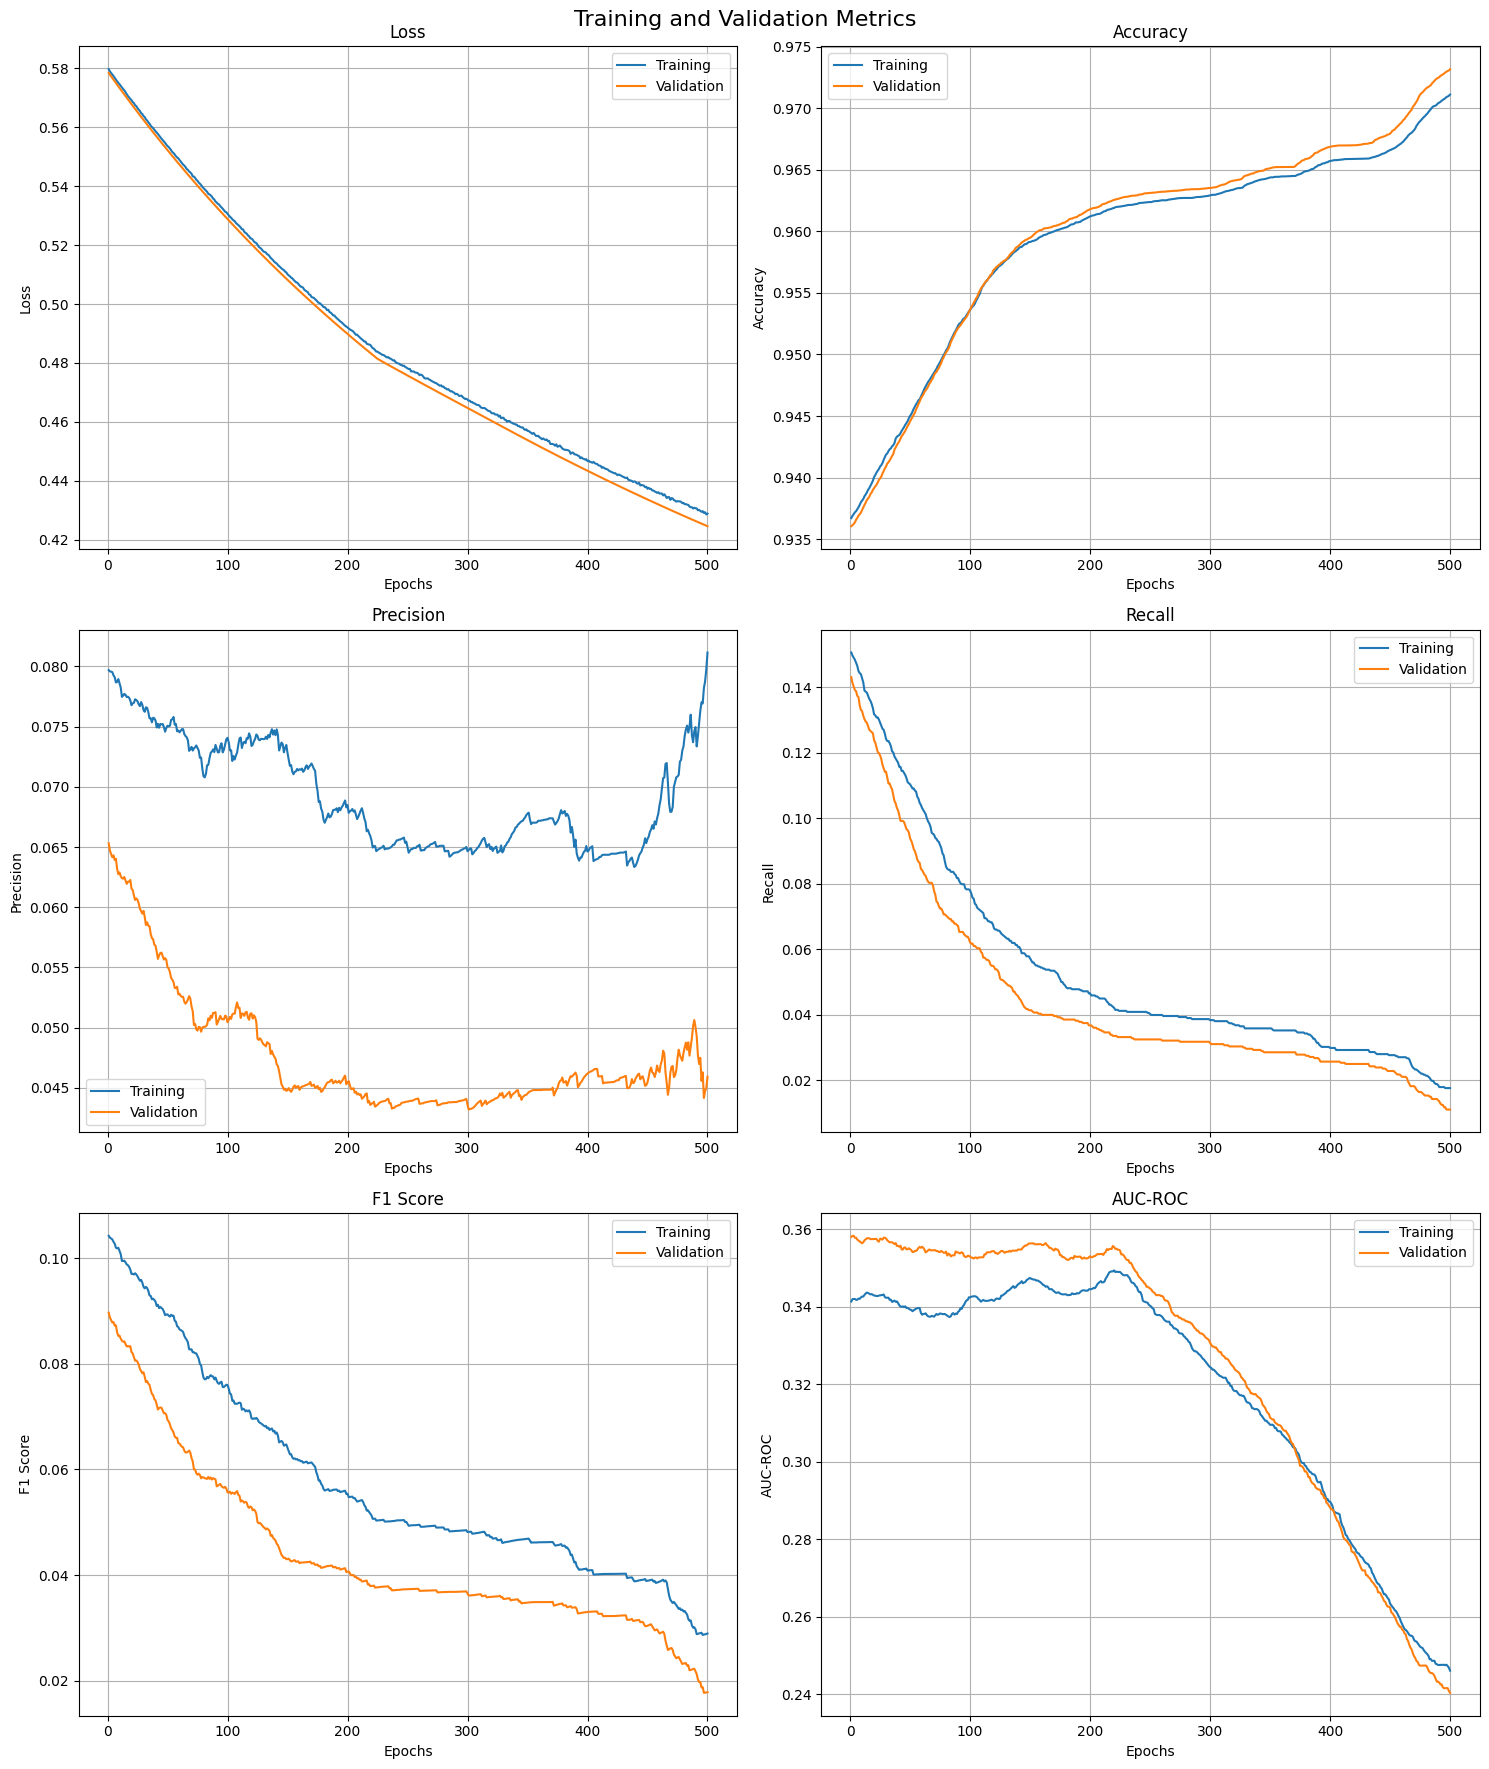

In [25]:
plot_result(metrics)

# 4. Evaluation

In [26]:
# BCE vs BCEWithLogitsLoss
y_true = np.array([0, 1, 1, 0, 1])
y_pred = np.array([0.1, 0.9, 0.8, 0.2, 0.7])
y_pred_sigmoid = torch.sigmoid(torch.tensor(y_pred))

bce_loss = nn.BCELoss()
bce_logits_loss = nn.BCEWithLogitsLoss()

bce = bce_loss(torch.tensor(y_pred_sigmoid), torch.tensor(y_true, dtype=torch.float32))
bce_logits = bce_logits_loss(
    torch.tensor(y_pred), torch.tensor(y_true, dtype=torch.float32)
)

print("BCE Loss:", bce.item())
print("BCE with Logits Loss:", bce_logits.item())

BCE Loss: 0.5315952301025391
BCE with Logits Loss: 0.5315952301025391


/var/folders/y2/hzjfncr92llg100m08nwxmhc0000gn/T/ipykernel_29572/3529295161.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bce = bce_loss(torch.tensor(y_pred_sigmoid), torch.tensor(y_true, dtype=torch.float32))


In [27]:
test_results = evaluate_epoch(model, criterion, test_dataloader, device)
pprint(test_results)


{'accuracy': 0.9752620458602905,
 'auc': 0.25220340490341187,
 'f1': 0.017246685922145844,
 'loss': 0.42385368049144745,
 'precision': 0.04416403919458389,
 'recall': 0.010715652257204056}


In [28]:
# 1st sample prediction
fold2_dataset = fold_datasets[2]
X_i, y_i = fold2_dataset[0]
X_i = torch.tensor(X_i).unsqueeze(0).to(device)
y_i = torch.tensor(y_i).unsqueeze(0).to(device)
predictions = model(X_i)
predictions = torch.sigmoid(predictions)
binary_preds = (predictions > 0.5).float()
print("Predictions:", binary_preds[0][:30])
print("Actual:", y_i[0][:30])

Predictions: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.])
Actual: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.])
